
# Aula P02 – Minimização com AMBER no Jupyter Lab

Este notebook mostra como executar a **minimização inicial de um sistema molecular** com o `sander` (AMBER) a partir de uma estrutura e topologia fornecidas. Em seguida, continuamos a minimização a partir da estrutura final da etapa anterior e analisamos o comportamento da energia total ao longo dos passos.

## Etapas:
1. Rodar minimização inicial
2. Converter para `.pdb`
3. Analisar e plotar energia
4. Rodar nova minimização partindo da estrutura anterior


In [38]:
root = '/home/lpdf03/Downloads/Aula_P01_Juliana/Aula-P02'
pattpath = 'cl-rm1-qmmm' # +2

In [39]:
# Rodar minimização inicial
!bash /home/lpdf03/Downloads/Aula_P01_Juliana/Aula-P02/1-run_init_min.sh


>>> Rodando minimização inicial...
Minimização inicial concluída!
Convertendo estrutura final para PDB
Conluído!


## A fazer
### Íons
* Cl ▶️
* Br
* CSN
---
### Métodos
* AM1 -ok
* PM3
* PM6 -ok
* RM1 ▶️
* DFTB -nao para Cl
* DFTB3

# 📈 1. Energia ao longo da minimização inicial

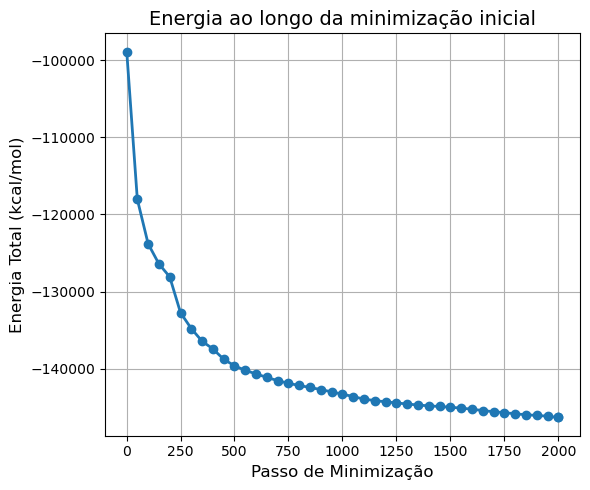

In [44]:
import matplotlib.pyplot as plt
import re

steps = []
energies = []

with open(f"{root}/{pattpath}/min.init.log") as f:
    for line in f:
        if re.match(r'^\s*\d+\s+-?\d+\.\d+', line):
            parts = line.split()
            try:
                steps.append(int(parts[0]))
                energies.append(float(parts[1]))
            except (IndexError, ValueError):
                continue

plt.figure(figsize=(6, 5))
plt.plot(steps, energies, marker='o', linewidth=2)
plt.xlabel("Passo de Minimização", fontsize=12)
plt.ylabel("Energia Total (kcal/mol)", fontsize=12)
plt.title("Energia ao longo da minimização inicial", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

---
### ▶️ Continuação da minimização

Usamos como entrada a estrutura final da minimização anterior (`min.init.rst`) para continuar o processo com o mesmo input. A saída será `min.cont.rst`.


In [14]:

!sander -O \
  -i /home/lpdf03/Downloads/Aula_P01_Juliana/Aula-P02/data/min_init.in \
  -p /home/lpdf03/Downloads/Aula_P01_Juliana/Aula-P02/parm/3lcc_cl.prmtop \
  -c /home/lpdf03/Downloads/Aula_P01_Juliana/Aula-P02/cl-am1-qmmm/min.init.rst \
  -o /home/lpdf03/Downloads/Aula_P01_Juliana/Aula-P02/cl-am1-qmmm/min.cont.log \
  -r /home/lpdf03/Downloads/Aula_P01_Juliana/Aula-P02/cl-am1-qmmm/min.cont.rst


^C


### 📉 Energia ao longo da continuação da minimização

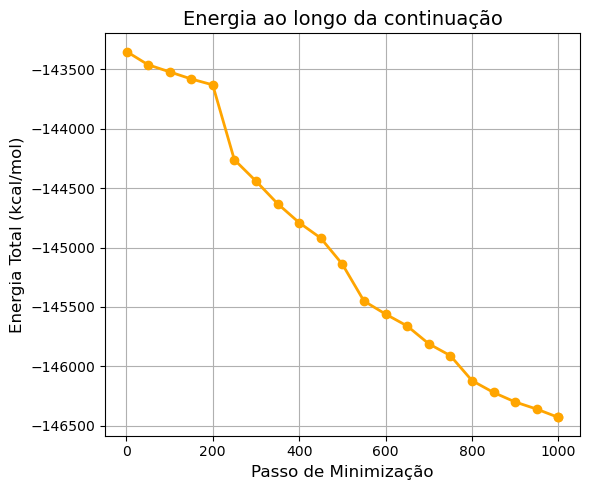

In [6]:
#*
steps2 = []
energies2 = []

with open(f'{root}/{pattpath}/min.cont.log') as f:
    for line in f:
        if re.match(r'^\s*\d+\s+-?\d+\.\d+', line):
            parts = line.split()
            try:
                steps2.append(int(parts[0]))
                energies2.append(float(parts[1]))
            except (IndexError, ValueError):
                continue

plt.figure(figsize=(6, 5))
plt.plot(steps2, energies2, marker='o', color='orange', linewidth=2)
plt.xlabel("Passo de Minimização", fontsize=12)
plt.ylabel("Energia Total (kcal/mol)", fontsize=12)
plt.title("Energia ao longo da continuação", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


### 📊 Comparação entre as duas minimizações

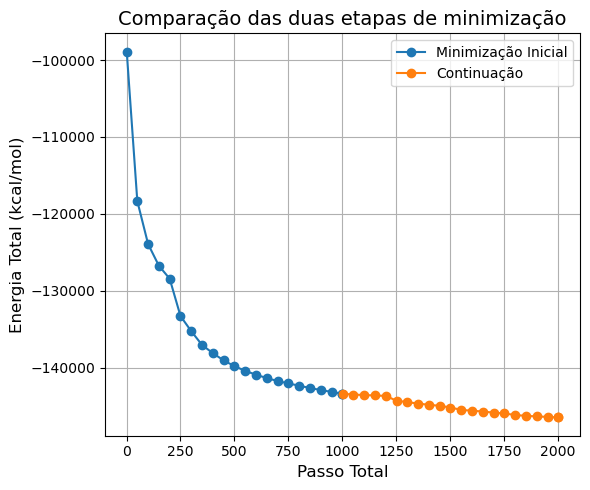

In [7]:
#ENERGIA TOTAL (DO SISTEMA TODO)
plt.figure(figsize=(6, 5))
plt.plot(steps, energies, label='Minimização Inicial', marker='o')
plt.plot([s + steps[-1] + 1 for s in steps2], energies2, label='Continuação', marker='o')
plt.xlabel("Passo Total", fontsize=12)
plt.ylabel("Energia Total (kcal/mol)", fontsize=12)
plt.title("Comparação das duas etapas de minimização", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 🔄 2. Continuação – Identificação de resíduos móveis e minimizações reacionais

Nesta parte, identificamos quais resíduos estão a até 5 Å do cofator SAM, geramos dinamicamente o arquivo de input com esses resíduos móveis, e então executamos minimizações ao longo de uma coordenada de reação (RC) variando de -2.0 a 1.0 Å.

### Etapas:
1. Identificar resíduos móveis com `cpptraj`
2. Criar arquivo de entrada `min_xmin3.i`
3. Rodar minimizações com diferentes valores de RC
4. Plotar curva de energia

### 📍 Identificar resíduos móveis a 5 Å de :SAM

In [40]:

%%bash
cd /home/lpdf03/Downloads/Aula_P01_Juliana/Aula-P02/cl-rm1-qmmm

echo ">>> Identificando resíduos móveis com cpptraj..."

cat <<EOF > tmp_move.in
parm ../parm/3lcc_cl.prmtop
reference min.init.rst
trajin min.init.rst
strip !(:SAM<:5.0)
trajout move.pdb pdb
EOF

cpptraj < tmp_move.in &> tmp_move.out
echo ">>> Terminado"

>>> Identificando resíduos móveis com cpptraj...
>>> Terminado


### 🧬 Gerar arquivo de input com os resíduos móveis

In [41]:
# PARA A ENERGIA DA REGIÃO DE INTERESSE (ONDE OCORRE A REAÇÃO + RESÍDUOS A 5 Å DE DISTÂNCIA)

# Extrair resíduos únicos do PDB gerado pelo cpptraj
with open(f"{root}/{pattpath}/move.pdb") as f:
    res_lines = [line for line in f if line.startswith("ATOM")]

# Extrair resSeq (coluna 22) e remover duplicatas
move_res = sorted(set(line[22:26].strip() for line in res_lines))
MOVE_RES = ",".join(move_res)

print("Resíduos móveis detectados:", MOVE_RES)

# Substituir no template
with open(f"{root}/data/min_reaction_temp.in") as f:
    template = f.read()

input_final = template.replace("MOVE", MOVE_RES)

with open(f"{root}/{pattpath}/min_xmin3.i", "w") as f:
    f.write(input_final)

print("Arquivo min_xmin3.i gerado com sucesso.")

Resíduos móveis detectados: 110,111,112,113,127,128,129,131,132,133,15,169,170,202,217,218,229,231,232,233,236,24,249,254,255,263,265,28,280,35,357,36,37,4471,4474,60,61,62,63,64,65,66,67,82,83,84,85,88
Arquivo min_xmin3.i gerado com sucesso.


# ⚙️ 3. Minimizações variando a coordenada de reação (RC)

In [ ]:
# MINIMIZA CADA PONTO DA TRAGETORIA (DE 0,1 EM 0,1)
import os
import subprocess

parm = f"{root}/parm/3lcc_cl.prmtop"
start_rst = "min.init.rst"
ref_rst = "min.init.rst"
min_input = "min_xmin3.i"
energies_path = "energies.dat"

os.chdir(f"{root}/{pattpath}")

with open(energies_path, "w") as f:
    f.write("RC\tEAMBER\n")

for i in range(41):  # de -2.0 a 1.0 com passo 0.1
    rc = round(-2.0 + i * 0.1, 1)
    rc_rst = f"min_rc{rc}.rst"
    rc_log = f"min_rc{rc}.log"

    # gerar rc.RST substituindo valor
    with open(f"{root}/data/rc_temp.RST") as f:
        rc_template = f.read()
    with open("rc.RST", "w") as f:
        f.write(rc_template.replace("RC", str(rc)))

    subprocess.run([
        "sander", "-O",
        "-i", min_input,
        "-p", parm,
        "-c", start_rst,
        "-ref", ref_rst,
        "-r", rc_rst,
        "-o", rc_log,
        "-inf", "mdinfo"
    ])

    # extrair energia do mdinfo
    with open("mdinfo") as f:
        for line in f:
            if "EAMBER" in line:
                eamber = float(line.split()[2])
                break

    with open(energies_path, "a") as f:
        f.write(f"{rc}\t{eamber:.4f}\n")

    start_rst = rc_rst  # atualizar entrada para próxima minimização



ERROR in load_lbfgs(): YS=0.

ERROR in load_lbfgs(): YS=0.

ERROR in load_lbfgs(): YS=0.

ERROR in load_lbfgs(): YS=0.

ERROR in load_lbfgs(): YS=0.


### 📊 Curva de energia ao longo da coordenada de reação

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
### 📊 Curva de energia ao longo da coordenada de reação
df = pd.read_csv(f"{root}/{pattpath}/energies.dat", sep='\t')
plt.figure(figsize=(6, 5))
plt.plot(df["RC"], df["EAMBER"], marker='o', linewidth=2)
plt.xlabel("Coordenada de Reação (RC)", fontsize=12)
plt.ylabel("Energia EAMBER (kcal/mol)", fontsize=12)
plt.title("Perfil de energia ao longo da reação", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


---
### Estender a curva de energia ao longo da coordenada de reação até 2.0

In [5]:
#CONTINUAÇÃO DA REAÇÃO 
#(porque a coordenada de reação não apresentou um "fundo" na etapa anterior -- que agora foi aumentada a janela de 31 pra 41)
import os
import subprocess

parm = f"{root}/parm/3lcc_cl.prmtop"
start_rst = "min_rc1.0.rst"  # última estrutura gerada no loop anterior
ref_rst = "min.cont.rst"
min_input = "min_xmin3.i"
energies_path = "energies.dat"

os.chdir(f"{root}/{pattpath}")

for i in range(10):  # de 1.1 a 2.0 com passo de 0.1
    rc = round(1.1 + i * 0.1, 1)
    rc_rst = f"min_rc{rc}.rst"
    rc_log = f"min_rc{rc}.log"

    # gerar rc.RST substituindo valor
    with open(f"{root}/data/rc_temp.RST") as f:
        rc_template = f.read()
    with open("rc.RST", "w") as f:
        f.write(rc_template.replace("RC", str(rc)))

    subprocess.run([
        "sander", "-O",
        "-i", min_input,
        "-p", parm,
        "-c", start_rst,
        "-ref", ref_rst,
        "-r", rc_rst,
        "-o", rc_log,
        "-inf", "mdinfo"
    ])

    # extrair energia do mdinfo
    with open("mdinfo") as f:
        for line in f:
            if "EAMBER" in line:
                eamber = float(line.split()[2])
                break

    with open(energies_path, "a") as f:
        f.write(f"{rc}\t{eamber:.4f}\n")

    start_rst = rc_rst  # atualizar entrada para próxima minimização



ERROR in load_lbfgs(): YS=0.

ERROR in load_lbfgs(): YS=0.

ERROR in load_lbfgs(): YS=0.

ERROR in load_lbfgs(): YS=0.

ERROR in load_lbfgs(): YS=0.

ERROR in load_lbfgs(): YS=0.

ERROR in load_lbfgs(): YS=0.

ERROR in load_lbfgs(): YS=0.


### 📊 Curva de energia ao longo da coordenada de reação completa (RC -2 a RC 2) usando energias relativas em kcal/mol

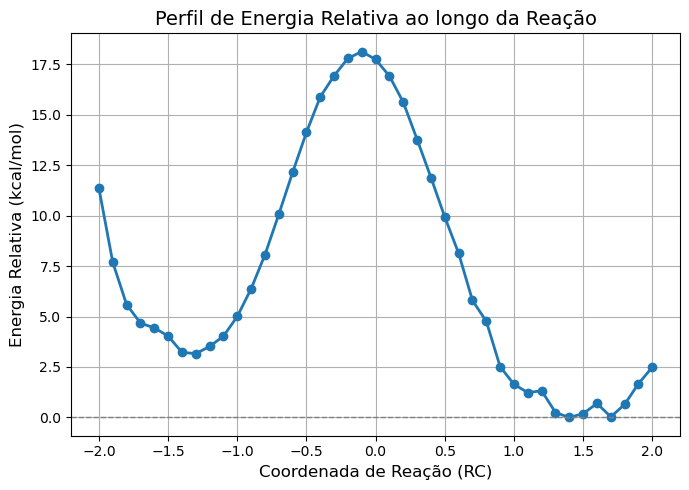

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Caminho para o arquivo de energias
df = pd.read_csv(f"{root}/{pattpath}/energies.dat", sep='\t')

# Converter energia absoluta para energia relativa (subtrai menor energia)
min_energy = df["EAMBER"].min()
df["E_relativa"] = df["EAMBER"] - min_energy

# Plot
plt.figure(figsize=(7, 5))
plt.plot(df["RC"], df["E_relativa"], marker='o', linewidth=2)
plt.xlabel("Coordenada de Reação (RC)", fontsize=12)
plt.ylabel("Energia Relativa (kcal/mol)", fontsize=12)
plt.title("Perfil de Energia Relativa ao longo da Reação", fontsize=14)
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.grid(True)
plt.tight_layout()
plt.show()
